##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [2]:
# !pip install -q imageio
# !pip install -q opencv-python
# !pip install -q git+https://github.com/tensorflow/docs

In [3]:
from matplotlib import pyplot as plt
import mediapipe as mp
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense
import pandas as pd
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [5]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [6]:
left_shoulder = []
right_shoulder = []
left_elbow = []
right_elbow = []
left_wrist = []
right_wrist = []
left_hip = []
right_hip = []
left_knee = []
right_knee = []
left_ankle = []
right_ankle = []

import math

def calculate_angles(firstPoint, midPoint, lastPoint):
  # Same formula from the Android App for consistency
  result = math.degrees(math.atan2(lastPoint[1]  - midPoint[1], lastPoint[0] - midPoint[0]) - math.atan2(firstPoint[1] - midPoint[1], firstPoint[0] - midPoint[0]))
  result = abs(result) # Angle should never be negative
  # 
  if result > 180:
      result = 360.0 - result # Always get the acute representation of the angle
  return result

In [19]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores
  
  def movenet(input_image, keypoint_indices):
    """Runs detection on an input image and prints the x and y coordinates of
    the keypoints at index keypoint_indices.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
      keypoint_indices: A list of integers representing the indices of the keypoints
        to print the x and y coordinates of.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    input_image = tf.cast(input_image, dtype=tf.int32)
    outputs = model(input_image)
    keypoints_with_scores = outputs['output_0'].numpy()

    for index in keypoint_indices:
        x, y = keypoints_with_scores[0, 0, index, :2]
        if index == 5:
          left_shoulder = [x, y]
        if index == 6:
          right_shoulder = [x, y]
        if index == 7:
          left_elbow = [x, y]
        if index == 8:
          right_elbow = [x, y]
        if index == 9:
          left_wrist = [x, y]
        if index == 10:
          right_wrist = [x, y]
        if index == 11:
          left_hip = [x, y]
        if index == 12:
          right_hip = [x, y]
        if index == 13:
          left_knee = [x, y]
        if index == 14:
          right_knee = [x, y]
        if index == 15:
          left_ankle = [x, y]
        if index == 16:
          right_ankle = [x, y]

        print(f"Keypoint {index} - x:{x}, y:{y}")

    left_elbow_angles = calculate_angles(left_wrist, left_elbow, left_shoulder)
    right_elbow_angles = calculate_angles(right_wrist, right_elbow, right_shoulder)
    left_shoulder_angles = calculate_angles(left_elbow, left_shoulder, left_hip)
    right_shoulder_angles = calculate_angles(right_elbow, right_shoulder, right_hip)
    left_hip_angles = calculate_angles(left_shoulder, left_hip, left_knee)
    right_hip_angles = calculate_angles(right_shoulder, right_hip, right_knee)
    left_knee_angles = calculate_angles(left_hip, left_knee, left_ankle)
    right_knee_angles = calculate_angles(right_hip, right_knee, right_ankle)
  

    if (left_elbow_angles is None or right_elbow_angles is None or left_shoulder_angles is None or
        right_shoulder_angles is None or left_hip_angles is None or right_hip_angles is None or
        left_knee_angles is None or right_knee_angles is None):
        print("Skipped - some angles are null.")
    else:
      golfdataset = pd.DataFrame([[left_elbow_angles, right_elbow_angles, left_shoulder_angles, right_shoulder_angles, left_hip_angles, right_hip_angles, left_knee_angles, right_knee_angles, 5]], columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', "Label"])
      golfdataset.to_csv('GolfMovenetData.csv', mode='a', index=False, header=False)

    return keypoints_with_scores

# left_elbow_angles = calculate
# right_elbow_angles = []
# left_shoulder_angles = []
# right_shoulder_angles = []
# left_hip_angles = []
# right_hip_angles = []
# left_knee_angles = []
# right_knee_angles = []

# L and R Angle:
# *Elbow = Wrist, Elbow, Shoulder
# *Shoulder = Elbow, Shoulder, Hip
# *Hips = Shoulder, Hip, Knee
# *Knee = Hip, Knee, Heel

In [20]:
import cv2
import os


ctr = 0
skipped = 0
image_dir = './GolfDB_Dataset/Mid-Follow-Through/'

image_filenames = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)
                   if os.path.isfile(os.path.join(image_dir, filename))]

image_filenames = sorted(image_filenames, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

for filename in image_filenames:
    image_path = filename
    
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    keypoints_with_scores = movenet(input_image, keypoint_indices)

    if tf.reduce_any(keypoints_with_scores[0, 0, :, 2] < 0.5):
        skipped += 1
        continue

    ctr += 1
    # if ctr >= 450:
    #     break

    # # Visualize the predictions with image.
    # display_image = tf.expand_dims(image, axis=0)
    # display_image = tf.cast(tf.image.resize_with_pad(
    #     display_image, 1280, 1280), dtype=tf.int32)
    # output_overlay = draw_prediction_on_image(
    #     np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

    # cv2.imshow('output_overlay', output_overlay)
    # key = cv2.waitKey(0) & 0xFF
    # if key == ord('q'):
    #     break
    # elif key == ord('e'):
    #     os.remove(filename)
    #     print(f"{filename} removed.")

print(f"Processed {ctr} files, skipped {skipped} files due to low confidence score.")
cv2.destroyAllWindows()

Keypoint 0 - x:0.29440975189208984, y:0.43272730708122253
Keypoint 1 - x:0.2876538038253784, y:0.43318817019462585
Keypoint 2 - x:0.2891937792301178, y:0.43019410967826843
Keypoint 3 - x:0.28881391882896423, y:0.4416179358959198
Keypoint 4 - x:0.2916320562362671, y:0.4318857789039612
Keypoint 5 - x:0.33762866258621216, y:0.46816790103912354
Keypoint 6 - x:0.3504253327846527, y:0.43716901540756226
Keypoint 7 - x:0.40172386169433594, y:0.5144988298416138
Keypoint 8 - x:0.4164542853832245, y:0.4388417601585388
Keypoint 9 - x:0.4417833089828491, y:0.49611371755599976
Keypoint 10 - x:0.457159161567688, y:0.453917920589447
Keypoint 11 - x:0.4777778089046478, y:0.49651890993118286
Keypoint 12 - x:0.47999900579452515, y:0.46261879801750183
Keypoint 13 - x:0.5828712582588196, y:0.5114231109619141
Keypoint 14 - x:0.5853825211524963, y:0.42095184326171875
Keypoint 15 - x:0.6961489915847778, y:0.5270780324935913
Keypoint 16 - x:0.6869964599609375, y:0.368802011013031
Keypoint 0 - x:0.2853244543075

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

# Load the dataset
df = pd.read_csv('GolfMovenetData.csv' )
X = df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']]
X = X.values
print(X)
y = df[['Label']]
y = y.values

[]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


clf = SVC(kernel='linear', C=1)
clf.fit(X_scaled, y)

y_pred = clf.predict(X_scaled)

print(y_pred)
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

c:\Users\Crim\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Crim\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Crim\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Crim\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversio

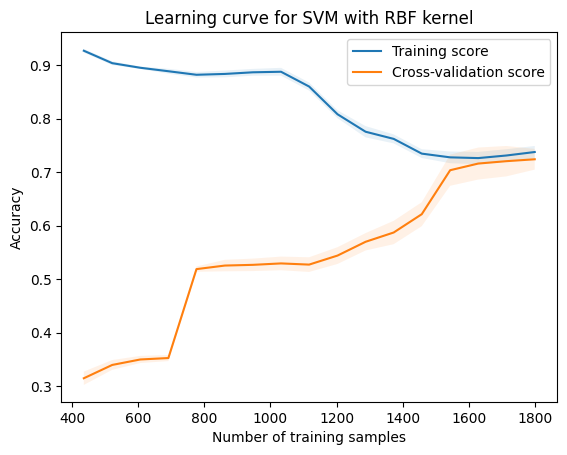

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 20)
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, train_sizes=train_sizes, cv=5)

# calculate the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.legend(loc='best')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning curve for SVM with RBF kernel')
plt.show()

In [ ]:
def test_movenet(input_image, keypoint_indices):
    """Runs detection on an input image and prints the x and y coordinates of
    the keypoints at index keypoint_indices.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
      keypoint_indices: A list of integers representing the indices of the keypoints
        to print the x and y coordinates of.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()

    for index in keypoint_indices:
        x, y = keypoints_with_scores[0, 0, index, :2]
        if index == 5:
          left_shoulder = [x, y]
        if index == 6:
          right_shoulder = [x, y]
        if index == 7:
          left_elbow = [x, y]
        if index == 8:
          right_elbow = [x, y]
        if index == 9:
          left_wrist = [x, y]
        if index == 10:
          right_wrist = [x, y]
        if index == 11:
          left_hip = [x, y]
        if index == 12:
          right_hip = [x, y]
        if index == 13:
          left_knee = [x, y]
        if index == 14:
          right_knee = [x, y]
        if index == 15:
          left_ankle = [x, y]
        if index == 16:
          right_ankle = [x, y]

    left_elbow_angles = calculate_angles(left_wrist, left_elbow, left_shoulder)
    right_elbow_angles = calculate_angles(right_wrist, right_elbow, right_shoulder)
    left_shoulder_angles = calculate_angles(left_elbow, left_shoulder, left_hip)
    right_shoulder_angles = calculate_angles(right_elbow, right_shoulder, right_hip)
    left_hip_angles = calculate_angles(left_shoulder, left_hip, left_knee)
    right_hip_angles = calculate_angles(right_shoulder, right_hip, right_knee)
    left_knee_angles = calculate_angles(left_hip, left_knee, left_ankle)
    right_knee_angles = calculate_angles(right_hip, right_knee, right_ankle)
  

    if (left_elbow_angles is None or right_elbow_angles is None or left_shoulder_angles is None or
        right_shoulder_angles is None or left_hip_angles is None or right_hip_angles is None or
        left_knee_angles is None or right_knee_angles is None):
        print("Skipped - some angles are null.")
    else:
      golfdataset = pd.DataFrame([[left_elbow_angles, right_elbow_angles, left_shoulder_angles, right_shoulder_angles, left_hip_angles, right_hip_angles, left_knee_angles, right_knee_angles, 4]], columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', "Label"])
      golfdataset.to_csv('GolfMovenetData.csv', mode='a', index=False, header=False)

    return keypoints_with_scores
